In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
# from scipy.signal import argrelextrema
# from scipy.interpolate import CubicSpline

from astropy.io import fits as pyfits

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

Follow Tom Barclay's demo to read in data and make a quick/dirty light curve

In [3]:
file = 'k2-trappist1-unofficial-tpf-short-cadence.fits'

f = pyfits.open(file)
data = f[1].data

In [4]:
f[1].data['FLUX'].shape

(107968, 11, 11)

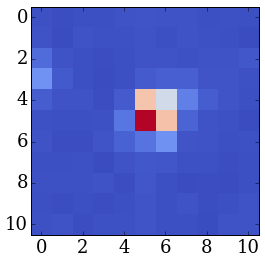

In [10]:
plt.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0][:,:])), cmap='coolwarm', aspect='equal', interpolation='nearest')
plt.tight_layout()

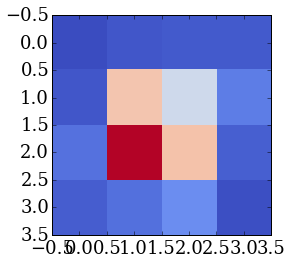

In [36]:
plt.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0][3:7,4:8])), cmap='coolwarm', aspect='equal', interpolation='nearest')
plt.tight_layout()

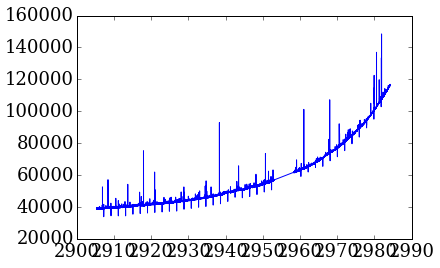

In [37]:
# The raw, total flux lightcurve of the entire postage stamp
plt.plot(f[1].data['TIME'], np.sum(f[1].data['FLUX'],axis=(1,2)))

Make a lightcurve using just the *center* of the postage stamp (hopefully just Trappist 1)

Then smooth it to take out long term trend, and clip low flux points (maybe some transits, probably a bunch of pointing adjustments)

In [38]:
fraw_pre = np.sum(f[1].data['FLUX'][:,3:7,4:8], axis=(1,2))

sky_pre1 = np.sum(f[1].data['FLUX'][:,0:2,4:8], axis=(1,2))
sky_pre2 = np.sum(f[1].data['FLUX'][:,9:,4:8], axis=(1,2))

time = f[1].data['TIME']
# fraw = np.sum(f[1].data['FLUX'],axis=(1,2))

fraw = fraw_pre - (sky_pre1 + sky_pre2)

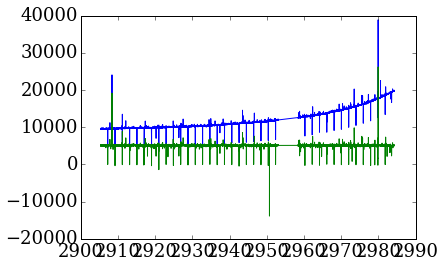

In [39]:
plt.plot(time, fraw_pre)
plt.plot(time, fraw)

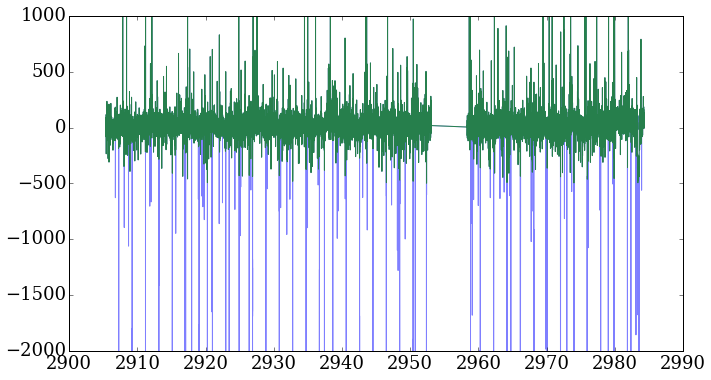

In [40]:
fit = np.polyfit(time, fraw, 4)
pp = np.poly1d(fit)

plt.figure(figsize=(11,6))
plt.plot(time, fraw - pp(time), alpha=0.5)
plt.ylim(-2000, 1000)

x = np.where((fraw - pp(time) > -500) & np.isreal(fraw) & np.isfinite(fraw))
plt.plot(time[x], fraw[x] - pp(time[x]), alpha=0.7)

(2979.8, 2980)

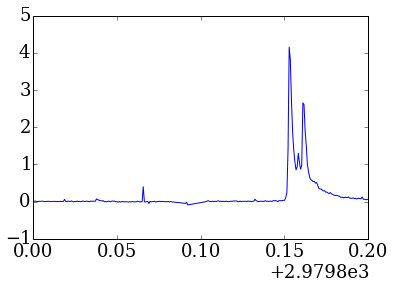

In [41]:
plt.plot(time[x], (fraw[x] - pp(time[x])) / np.median(fraw[x]))
plt.xlim(2979.8,2980)
# the flare that Tom Barclay found already (as of 730am, 2017-Mar-08)

Now smooth the light curve using rolling medians. Tried a couple, I like just using the coarse one (100 data point window)

(2979.8, 2980)

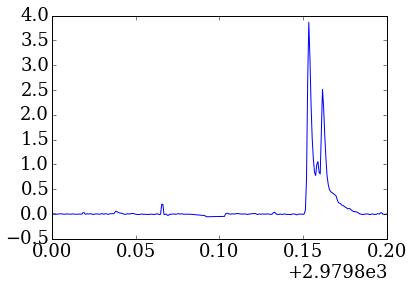

In [42]:
smo = pd.rolling_median(fraw[x], 100, center=True)

smo2 = pd.rolling_median(fraw[x] - smo, 2, center=True)

plt.plot(time[x], smo2 / np.median(fraw[x]))
plt.xlim(2979.8,2980)

Write the slightly cleaned up light curve to a file.

This will be analyzed using [FBEYE](https://github.com/jradavenport/FBEYE), the Flares-By-EYE toolkit I wrote in IDL years back!

I would prefer to get the flares automatically using [appaloosa](https://github.com/jradavenport/appaloosa), which also does artificial flare injection/recovery tests to determine completeness... but it's not working on my new laptop. Sad Face.

/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 107968 but corresponding boolean dimension is 106985


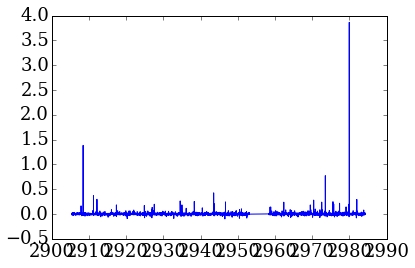

In [43]:
plt.plot(time[x], (smo2) / np.median(fraw[x]))

y = np.isfinite(smo2)
dfout = pd.DataFrame(data={'time':time[x][y], 
                           'flux':(fraw[x][y] - smo[y]) / np.median(fraw[x]),
                          'error':np.zeros_like(time[y])})
dfout.to_csv('trappist.csv', columns=('time', 'flux','error'), index=False)

Now that I've found some flares with FBEYE, read them back in!

In [44]:
names = ('Event_ID','Start_INDX','Stop_INDX','t_peak','t_start','t_stop','t_rise','t_decay',
         'Flux_peak','Equiv_Dur','S/N','CPLX_flg','MLTPK_flg','MLTPK_num','t_MLTPK','L_mltpk',
         'MLTPK_INDX','quies','x')
fbeye = pd.read_table('trappist.csv.fbeye', delim_whitespace=True, header=None, names = names, comment='#')
fbeye

,Event_ID,Start_INDX,Stop_INDX,t_peak,t_start,t_stop,t_rise,t_decay,Flux_peak,Equiv_Dur,S/N,CPLX_flg,MLTPK_flg,MLTPK_num,t_MLTPK,L_mltpk,MLTPK_INDX,quies,x
0,0,-99,-99,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000000000000,0.000000,0.000000,0,0,0,0,0,0.000000,0.0000000000000000,;
1,1,9828,9867,2912.118733,2912.117371,2912.143934,0.001362,0.025201,5.4162427269978100,-94159.462046,NaN,1,0,0,0,0,0.000000,-0.0005200440549820,;
2,2,10972,11002,2912.899297,2912.897253,2912.917687,0.002043,0.018390,7.5070804844197454,-19323.304946,NaN,1,0,0,0,0,0.000000,-0.0005201776737020,;
3,3,11065,11086,2912.974220,2912.960597,2912.974901,0.013623,0.000681,5.9912992544587862,-7704.467475,NaN,1,0,0,0,0,0.000000,-0.0005201331341290,;
4,4,15449,15467,2916.025638,2916.025638,2916.037898,0.000000,0.012260,19.8311842581343498,-44744.754768,NaN,1,0,0,0,0,0.000000,-0.0001733480183270,;
5,5,15844,15866,2916.294680,2916.294680,2916.309665,0.000000,0.014985,2.5066198604083327,-21578.134834,NaN,1,0,0,0,0,0.000000,-0.0003468741949470,;
6,6,21056,21119,2919.880777,2919.871923,2919.914833,0.008854,0.034056,16.2122956280480146,-75584.619438,NaN,1,0,0,0,0,0.000000,-0.0003466960366550,;
7,7,24259,24269,2922.077378,2922.075335,2922.082146,0.002043,0.004768,35.6700831175871684,5002.235563,61.161278,1,0,0,0,0,0.000000,0.0008668291707840,;
8,8,26723,26763,2923.757020,2923.757020,2923.784265,0.000000,0.027245,9.6945592325605752,-30584.747882,NaN,1,0,0,0,0,0.000000,-0.0004333700458190,;
9,9,31342,31416,2926.960328,2926.929677,2926.980080,0.030650,0.019753,10.1748785157141022,-83317.773046,NaN,1,0,0,0,0,0.000000,-0.0006068071432920,;


FBEYE has some bug in the calculation of Equivalent Duration, so redo that here.

Steps:
* define continuum regions on both sides of the flare (c1, c2)
* fit straight line and subtract to remove any starspot or instrumental signal
* compute trapezoidal sum of fractional brightness within the flare


In [45]:
t = time[x][y]
flux = (fraw[x][y] - smo[y]) / np.median(fraw[x])

ED = np.zeros(len(fbeye)-1)

# the first entry is null, skip it
for k in range(1,len(fbeye)):
    xfl = np.where((t >= fbeye['t_start'].values[k]) & (t <= fbeye['t_stop'].values[k]))

    c1 = np.where((t <= fbeye['t_start'].values[k]-5.0/24./60.) & (t >= fbeye['t_start'].values[k]-0.1))
    c2 = np.where((t >= fbeye['t_stop'].values[k]+10.0/24./60.) & (t <= fbeye['t_stop'].values[k]-0.1))
    
    slope = (np.median(flux[c1])-np.median(flux[c2]))/(np.median(t[c1])-np.median(t[c2]))
    inter = np.median(flux[c1]) - slope*np.median(t[c1])
    fit = [inter,slope]
    
    ED[k-1] = np.trapz(flux[xfl], t[xfl]*86400.)

/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


The classic figure of merit for flare rates: the Flare Frequency Distribution (or FFD for short)

This presents the *cumulative* rate of flares at a given energy or higher

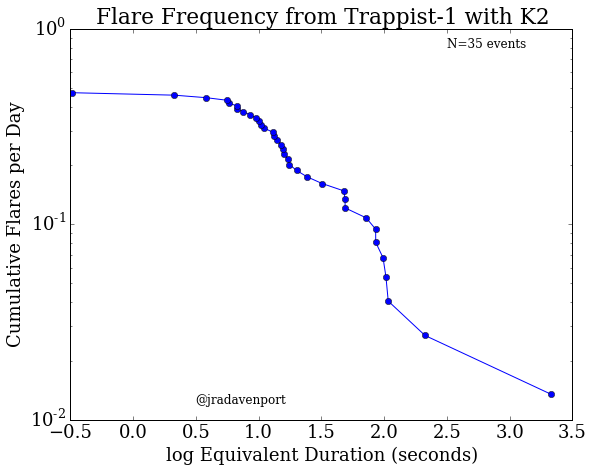

In [46]:
exptime = 1. / 24./60. # 1 min, in units of days
totdur = float(len(t)) * exptime

ss = np.argsort(ED)[::-1]

ffd_x = np.log10(ED[ss])
ffd_y = (np.arange(len(ffd_x)) + 1) / totdur


plt.figure(figsize=(9,7))
plt.plot(ffd_x, ffd_y, 'o-')
plt.yscale('log')
plt.ylim(1e-2,1e0)
plt.xlabel('log Equivalent Duration (seconds)')
plt.ylabel('Cumulative Flares per Day')

plt.title('Flare Frequency from Trappist-1 with K2')
plt.text(0.5, 1.2e-2, '@jradavenport', fontsize=12)
plt.text(2.5, 8e-1, 'N=35 events', fontsize=12)

plt.savefig('trappist_flares_ED.png')

Now I'll take an overly simplistic swing at converting the relative energy (Equiv Dur) to energy, by computing the quiescent luminosity of the star using the good-old-fashioned [blackbody luminosity](https://en.wikipedia.org/wiki/Luminosity#Luminosity_formula) we all learned as astronomy undergraduates!

NOTE: This is not very accurate, and doesn't take in to account:

* the luminosity *in the Kepler bandpass*
* the color or temperature of the flare event (typically about 10,000 K)
* the known distance of TRAPPIST-1

In [47]:
# way 1, blackbody (total Luminosity)
Teff = 2550.
sigma = 5.67051e-5
E_POINT = (4. * np.pi * (6.955e10 * 0.114)**2. * sigma * Teff**4.)


# way 2, compare to MOST-band luminosity for Proxima Cen, divide by 3 (from NLDS tbl 4.1)
L_m6_most = 10**28.69 # from Davenport et al. work on Proxima Cen
L_m8_m6 = L_m6_most / 3.


# way 3, scale from Sun (but again using total Lum)
# an independent calculation for New Light on Dark Stars (table 4.1)
L_sun = 3.826e33 # erg/s
L_m8 = 0.03e-2 * L_sun

print(E_POINT, L_m8, L_m8_m6)

(1.8940728451422425e+30, 1.1477999999999999e+30, 1.6325960645614922e+28)


In [48]:
# way 2 gives BEST estimate, since it's approx in the MOST bandpass, 
# and that in turn is close-ish to the Kepler bandpass... or close enough for messing about
E_POINT = L_m8_m6

print(E_POINT) # erg / s

1.63259606456e+28


[ -0.52956618  14.9027335 ]


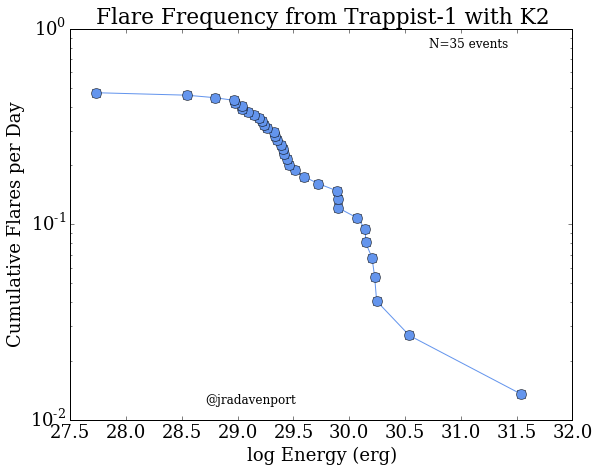

In [58]:

# fit a line to the Flare Freq Distribution
fit2 = np.polyfit(ffd_x + np.log10(E_POINT), np.log10(ffd_y), 1)
pp2 = np.poly1d(fit2)


plt.figure(figsize=(9,7))
plt.plot(ffd_x + np.log10(E_POINT), ffd_y, 'o-', c='cornflowerblue', markersize=10)

# plt.plot(ffd_x + np.log10(E_POINT), 10.**pp2(ffd_x + np.log10(E_POINT)) )

plt.yscale('log')
plt.ylim(1e-2,1e0)
plt.xlabel('log Energy (erg)')
plt.ylabel('Cumulative Flares per Day')

plt.title('Flare Frequency from Trappist-1 with K2')
plt.text(0.5+ np.log10(E_POINT), 1.2e-2, '@jradavenport', fontsize=12)
plt.text(2.5+ np.log10(E_POINT), 8e-1, 'N=35 events', fontsize=12)

plt.savefig('trappist_flares.png')

print(fit2)

In [50]:
print('A superflare every ' + str(1. / (10.**pp2(33.) * 365.)) + ' years')

A superflare every 1.02484374854 years


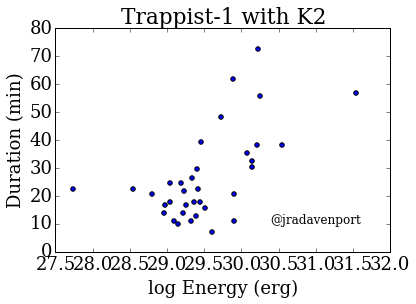

In [52]:
plt.scatter(np.log10(ED*E_POINT) , (fbeye['t_stop'].values[1:] - fbeye['t_start'].values[1:])*24.*60.)
plt.xlabel('log Energy (erg)')
plt.ylabel('Duration (min)')
plt.title('Trappist-1 with K2')
plt.text(30.4, 10, '@jradavenport', fontsize=12)